# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [488]:
# Import necessary libraries
import anndata
from mmcontext.pp.utils import consolidate_low_frequency_categories

data_path = "../../data/test_data/small_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)


# Display basic information about the dataset
print(adata)

# remove cells with less than 10 appearances
adata = consolidate_low_frequency_categories(adata, columns=["cell_type"], threshold=10, remove=True)
print(f"After removing low frequency cells: {adata}")

AnnData object with n_obs × n_vars = 5600 × 1000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'metadata_tissue_assay_cell_type', 'scvi'
After removing low frequency cells: AnnData object with n_obs × n_vars = 5212 × 1000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'metadata_tissue_assay_cell_type', 'scvi'


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


... storing 'cell_type' as categorical


<Figure size 800x800 with 0 Axes>

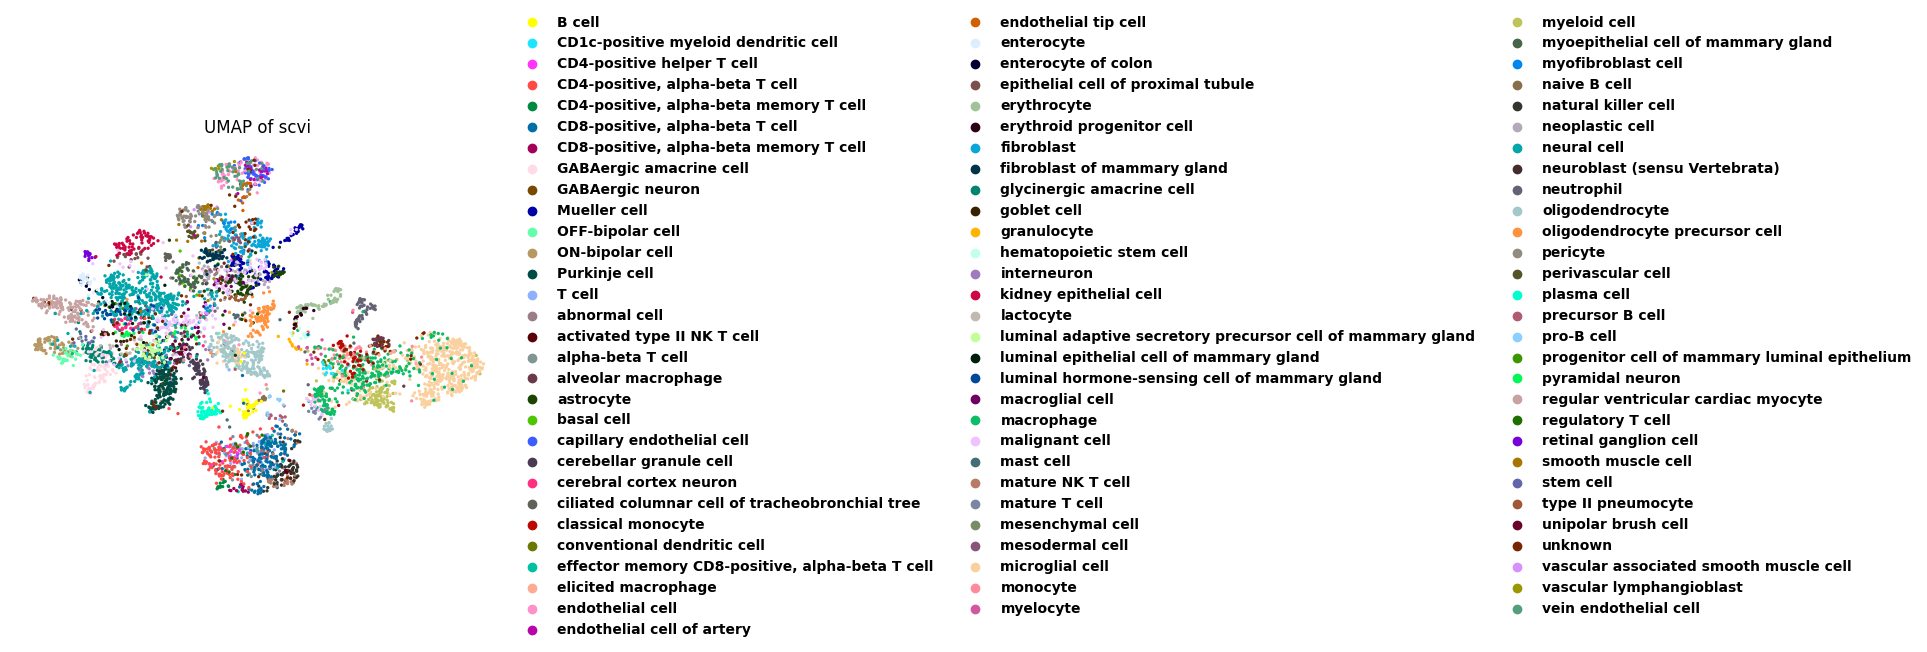

root - INFO - Displayed UMAP plot interactively.


In [489]:
from mmcontext.pl.plotting import plot_umap

plot_umap(adata, color_group="cell_type", embedding_key="scvi", save_plot=False)

#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [469]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])

# Confirm the shape of the context embeddings
print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (4068, 1536)
Data Embeddings Shape: (4068, 50)


#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [470]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
normalizer.normalize(adata)

# Confirm that normalized embeddings are stored
print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (4068, 50)
Normalized Context Embeddings Shape: (4068, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [471]:
# Configuration dictionary for PCA evaluation
config = {
    "evaluate_pca": False,
    "save_path": "pca_eval_oh",
    "scree_plot": True,
    "cumulative_variance_plot": True,
    "loadings_heatmap": True,
    "loadings_heatmap_options": {
        "threshold": 0,  # Only include loadings above this threshold
        "top_n_components": 40,  # Number of principal components to include in the heatmap
        "top_n_variables": 1000,  # Number of variables to display in the heatmap
    },
}
if config["evaluate_pca"] and one_hot:
    config["one_hot_order"] = adata.uns["one_hot_order"]

In [433]:
from mmcontext.pp.utils import split_anndata

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)

In [472]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
aligner.align(train_adata)
aligner.align(test_adata)

# Confirm that aligned embeddings are stored
print("Aligned Data Embeddings Shape:", train_adata.obsm["d_emb_aligned"].shape)
print("Aligned Context Embeddings Shape:", train_adata.obsm["c_emb_aligned"].shape)

Aligned Data Embeddings Shape: (4169, 64)
Aligned Context Embeddings Shape: (4169, 64)


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

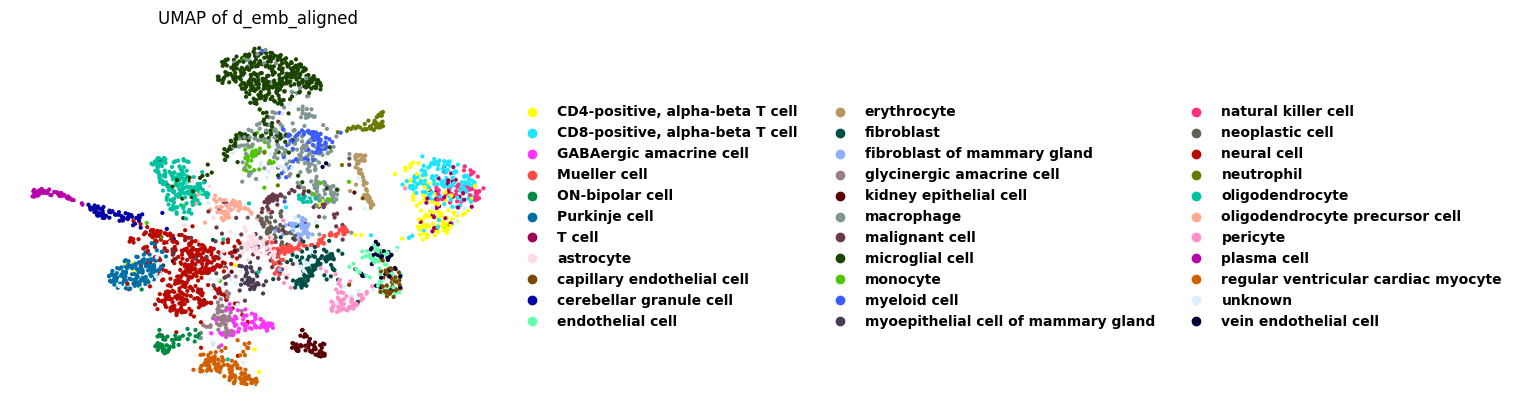

root - INFO - Displayed UMAP plot interactively.


In [282]:
# plot_umap(train_adata, color_group = "cell_type", embedding_key= "d_emb_aligned", save_plot = False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


<Figure size 800x800 with 0 Axes>

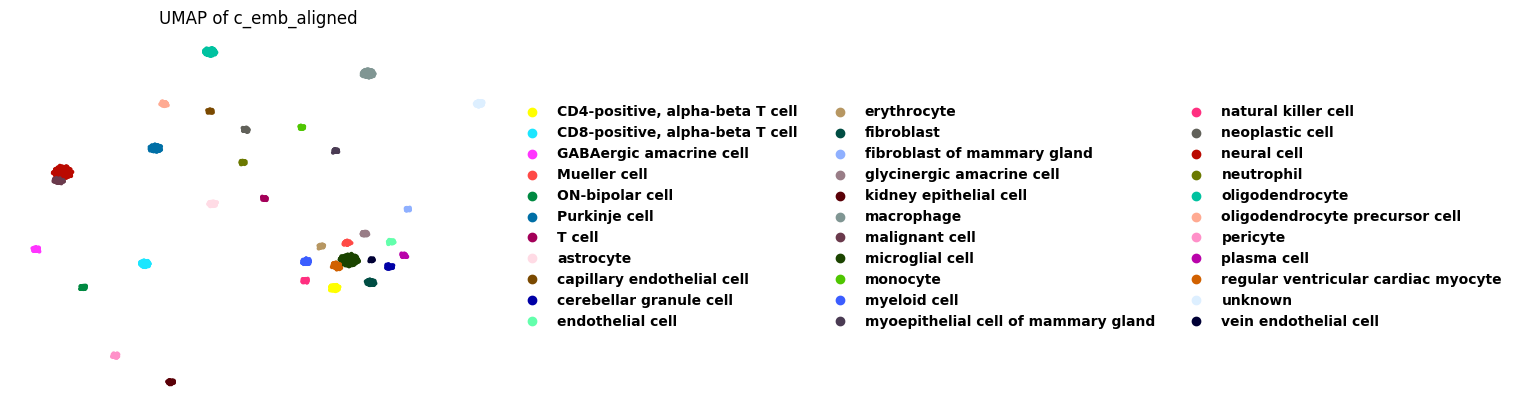

root - INFO - Displayed UMAP plot interactively.


In [131]:
# plot_umap(train_adata, color_group = "cell_type", embedding_key= "c_emb_aligned", save_plot = False)

#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [473]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")
test_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(train_adata)
test_dataset_constructor.add_anndata(test_adata)

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 12
# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [475]:
from torch.utils.data import DataLoader

# Create DataLoader
batch_size = 32  # Number of sequences per batch
if batch_size * seq_length > adata.n_obs:
    raise ValueError("Batch size and sequence length are too large for the dataset.")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["data_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["context_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    break  # Only need to check the first batch

torch.Size([32, 12, 64])
torch.Size([32, 12, 64])
torch.Size([32, 12])


### Model fitting
#### 1. Initializing the Model
The {class} `mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class} `torch.nn.TransformerEncoder` which creates stacks of the {class} `mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. An MLP only model
2. To apply self attention (use_self_attention = True)
3. To apply cross attention (use_cross_attention = True)
4. To use both self and cross attention (both True)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class} `mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [535]:
from mmcontext.engine import MMContextEncoder

hidden_dim = 64
num_layers = 2
num_heads = 1
model = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 2, use_self_attention = False, use_cross_attention = False.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class} `mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class} `mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class} `mmcontext.engine.LossFunction` is the {class} `mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [536]:
from mmcontext.engine import LossManager, ContrastiveLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func} `mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class} `mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [537]:
from mmcontext.engine import Trainer
import torch

trainer = Trainer(
    model=model,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model.parameters()),
    input_embeddings={"main": "data_embedding", "cross": "context_embedding"},
    temperature=0.07,
)
trainer.fit(train_loader, val_loader, epochs=50, save_path="model.pth")

mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 1/50
mmcontext.engine.trainer - INFO - Batch 10/11, Loss: 6.4208
mmcontext.engine.trainer - INFO - Batch 11/11, Loss: 6.1222
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 6.5581
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 6.4551
mmcontext.engine.trainer - INFO - Epoch 1/50 - Train Loss: 6.5581, Val Loss: 6.4551
mmcontext.engine.trainer - INFO - Attempting to save model...
mmcontext.engine.trainer - INFO - Validation loss improved. Model saved to model.pth
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 2/50
mmcontext.engine.trainer - INFO - Batch 10/11, Loss: 6.2142
mmcontext.engine.trainer - INFO - Batch 11/11, Loss: 5.9630
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 6.1906
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 6.2660
mmcon

In [538]:
# The fitted model can be used to create universial embeddings
model.load(file_path="model.pth")
trainer = Trainer(
    model=model, input_embeddings={"main": "data_embedding", "cross": "context_embedding"}, temperature=0.07
)
inferred_adata = trainer.infer_adata(
    test_adata, sample_id_key="soma_joinid", seq_length=seq_length, batch_size=batch_size
)

mmcontext.engine.models - INFO - Loading model state dictionary from model.pth
mmcontext.engine.trainer - WARNING - Sample ID 50131236 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 59126216 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 20476531 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 1095400 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 49362756 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 14624586 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 808993 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 50358493 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 58488751 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 58494368 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample 

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


... storing 'cell_type' as categorical


<Figure size 800x800 with 0 Axes>

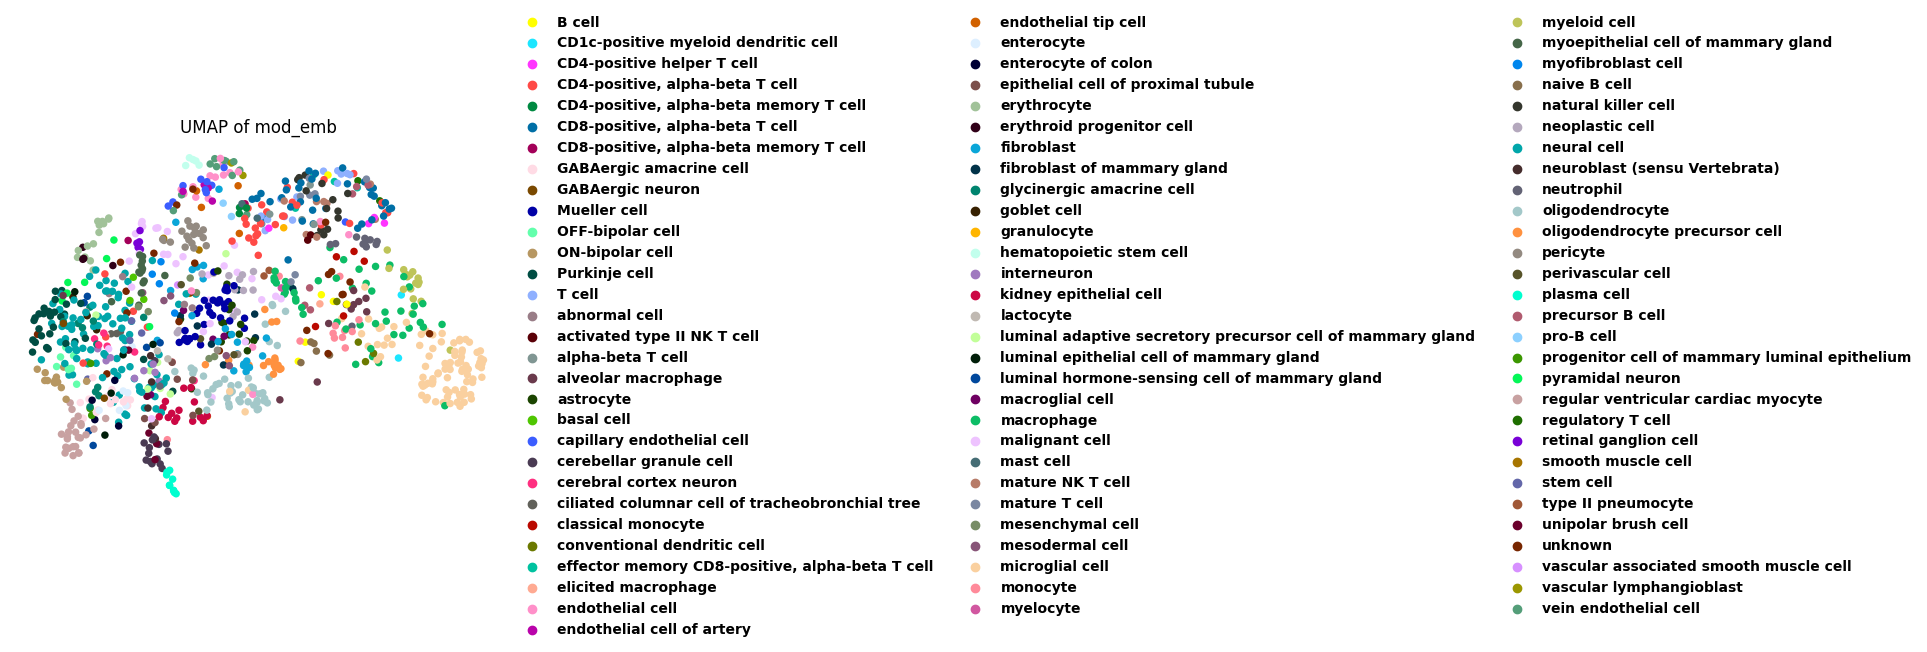

root - INFO - Displayed UMAP plot interactively.


In [539]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

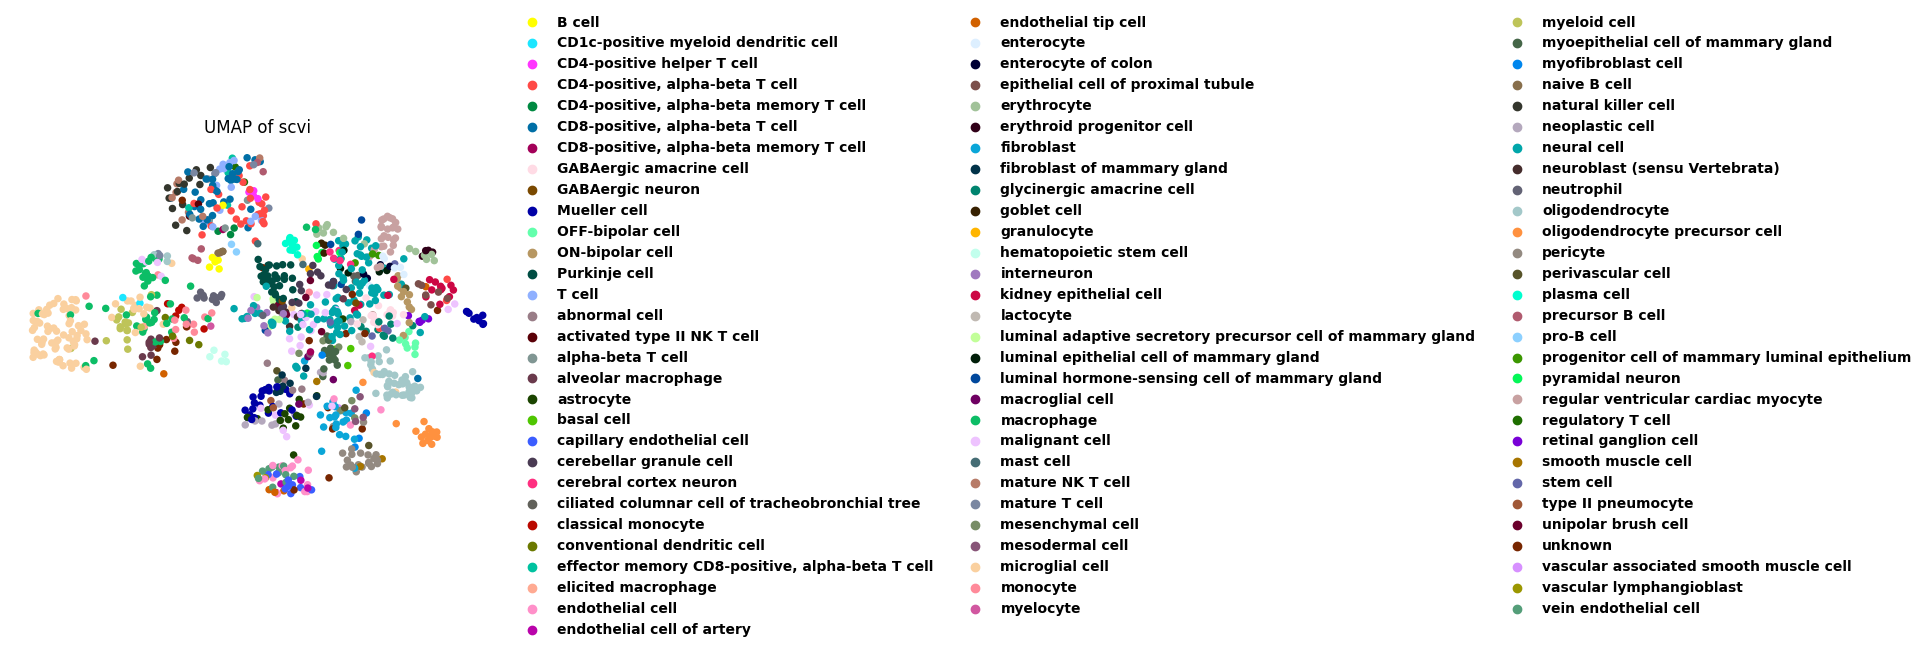

root - INFO - Displayed UMAP plot interactively.


In [486]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="scvi", save_plot=False)